In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU



In [6]:
# Carregamento do dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preparação do dataset
dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, axis=-1).astype(np.float32) / 255

batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Construção do gerador
noise_dim = 150




In [7]:
generator = tf.keras.Sequential([
    layers.Input(shape=(noise_dim,)),
    layers.Dense(7 * 7 * 256),
    layers.Reshape(target_shape=(7, 7, 256)),
    layers.Conv2DTranspose(256, 3, strides=2, padding="SAME"),
    LeakyReLU(0.1),
    layers.Conv2DTranspose(128, 3, strides=2, padding="SAME"),
    LeakyReLU(0.1),
    layers.Conv2DTranspose(1, 3, padding="SAME", activation="sigmoid")
])
generator.summary()

# Construção do discriminador
discriminator = tf.keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(256, 3, strides=2, padding="SAME", activation='relu'),
    layers.Conv2D(128, 3, strides=2, padding="SAME", activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
discriminator.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,894,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,153 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,780,417 (10.61 MB)

 Trainable params: 2,780,417 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,137 (2.67 MB)

 Trainable params: 699,137 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Otimização e Função de perda
optmG = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
optmD = keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# Métricas
gAccMetric = keras.metrics.BinaryAccuracy()
dAccMetric = keras.metrics.BinaryAccuracy()

@tf.function
def trainGstep(data):
    BatchSize = tf.shape(data)[0]
    noise = tf.random.normal(shape=(BatchSize, noise_dim))
    y_true = tf.ones(BatchSize, 1)
    with tf.GradientTape() as tape:
        y_pred = discriminator(generator(noise))
        generator_loss = lossFn(y_true, y_pred)
    grads = tape.gradient(generator_loss, generator.trainable_weights)
    optmG.apply_gradients(zip(grads, generator.trainable_weights))
    gAccMetric.update_state(y_true, y_pred)
    return {
        "g_loss": generator_loss,
        "g_acc": gAccMetric.result()
    }

@tf.function
def trainDstep(data):
    BatchSize = tf.shape(data)[0]
    noise = tf.random.normal(shape=(BatchSize, noise_dim))

    y_true = tf.concat([tf.ones(BatchSize, 1), tf.zeros(BatchSize, 1)], axis=0)

    with tf.GradientTape() as tape:
        fake = generator(noise)
        x = tf.concat([data, fake], axis=0)
        y_pred = discriminator(x)
        discriminator_loss = lossFn(y_true, y_pred)
    grads = tape.gradient(discriminator_loss, discriminator.trainable_weights)
    optmD.apply_gradients(zip(grads, discriminator.trainable_weights))
    dAccMetric.update_state(y_true, y_pred)
    return {
        "d_loss": discriminator_loss,
        "d_acc": dAccMetric.result()
    }

# Função para plotar imagens geradas
def plotImages(model, noise_dim, n_images=81):
    noise = np.random.normal(size=(n_images, noise_dim))
    images = model(noise)
    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9, 9, i + 1)
        plt.imshow(np.squeeze(image, -1), cmap='Greys_r')
        plt.axis('off')
    plt.show()



c:\Users\daneil\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


E:0, Loss G:2.3509, Loss D:0.2521, Acc G:%4.54, Acc D:%91.66


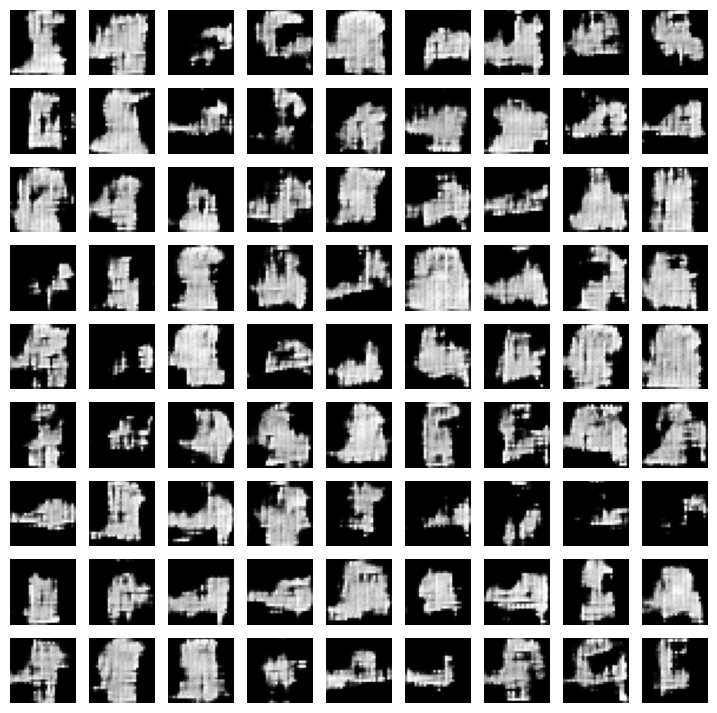

E:1, Loss G:2.0322, Loss D:0.3038, Acc G:%6.49, Acc D:%90.23


In [9]:
# Treinamento
for epoch in range(2):
    dlossSum, daccSum = 0, 0
    glossSum, gaccSum = 0, 0
    cnt = 0

    for batch in dataset:
        dloss = trainDstep(batch)
        dlossSum += dloss["d_loss"]
        daccSum += dloss["d_acc"]
        gloss = trainGstep(batch)
        glossSum += gloss["g_loss"]
        gaccSum += gloss["g_acc"]
        cnt += 1

    print(f"E:{epoch}, Loss G:{glossSum/cnt:.4f}, Loss D:{dlossSum/cnt:.4f}, Acc G:%{100*gaccSum/cnt:.2f}, Acc D:%{100*daccSum/cnt:.2f}")

    if epoch % 2 == 0:
        plotImages(generator, noise_dim)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


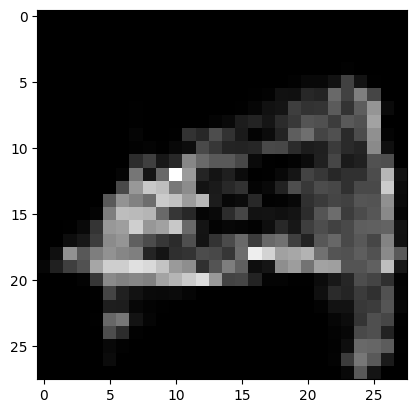

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
[[0.23677227]]


In [10]:
# Geração de imagens e validação
noise = np.random.normal(0, 1, (1, noise_dim))
generated_image = generator.predict(noise)
generated_image = 0.5 * generated_image + 0.5

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

print(discriminator.predict(generated_image))



In [11]:
# Classificação de imagens
real = []
falso = []
while len(real) < 10 or len(falso) < 10:
    noise = np.random.normal(0, 1, (1, noise_dim))
    generated_image = generator.predict(noise)
    generated_image = 0.5 * generated_image + 0.5
    prediction = discriminator.predict(generated_image)
    if prediction >= 0.70 and len(real) < 10:
        real.append(generated_image)
    elif prediction < 0.70 and len(falso) < 10:
        falso.append(generated_image)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

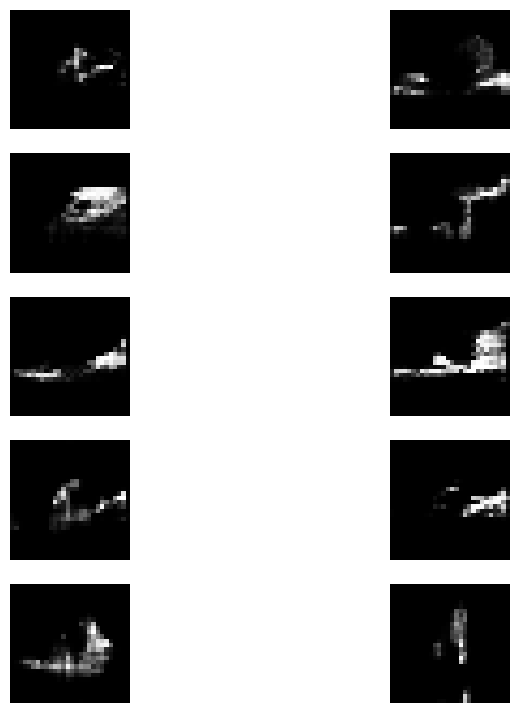

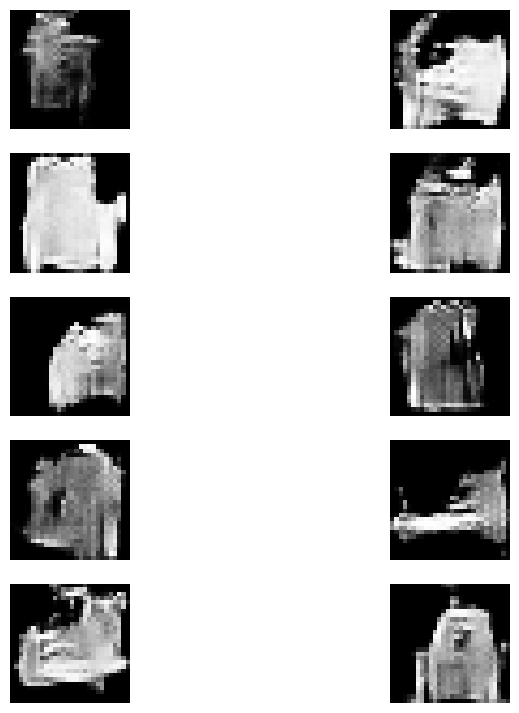

In [12]:
# Plot das imagens reais
plt.figure(figsize=(9, 9))
for i, image in enumerate(real):
    plt.subplot(5, 2, i + 1)
    plt.imshow(np.squeeze(image), cmap="Greys_r")
    plt.axis('off')
plt.show()

# Plot das imagens falsas
plt.figure(figsize=(9, 9))
for i, image in enumerate(falso):
    plt.subplot(5, 2, i + 1)
    plt.imshow(np.squeeze(image), cmap="Greys_r")
    plt.axis('off')
plt.show()